In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('analytical_data_withadditions.csv', sep=';')
target_df = pd.read_csv('20201020_tabular_data/target.csv')

df_l = pd.merge(df, target_df, on = ["tile_h", "tile_v"])
df_predict = df[df.has_target != 1]

In [3]:
# drop non-useful columns for the supervised learning models
drop_cols = ['Unnamed: 0', 'block_size', 'elevation_sd', 'degree_of_slope_sd', 'has_target', 'Name', 'degree_of_slope_min', 'elevation_min', 'Population_1990', 'Population_2000', 'delta_unemployed' ]
df_l.drop(drop_cols, axis=1 ,inplace=True)

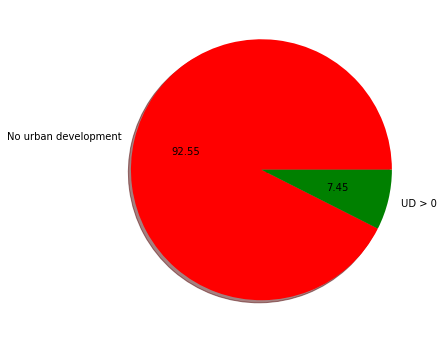

In [4]:
#Most values are zero!
plt.pie([df_l.target[df_l.target == 0].shape[0],df_l.target[df_l.target > 0].shape[0]],labels=['No urban development','UD > 0'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)

In [7]:
# If I ran immediately a learning regression model I would definitely get overfitting

In [5]:
df_l = df_l.fillna(0)
#Declare targets
y = df_l['target'].values
x=df_l.drop(['target'],axis=1).values

In [9]:
# First I will run a classifier, that will tell me whether target is 0 or a value greater than zero

In [6]:
# creation of a variable that contains only ones and zeros
y_class = np.where(y > 0, 1, 0)

In [11]:
#The splitting can be done using the tools provided by sklearn:
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier()

PRC = 0.1
X_train, X_test, y_train, y_test = train_test_split(x, y_class, test_size=PRC)

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.export('tpot_classifier.py')


Generation 1 - Current best internal CV score: 0.9476423092585458
Generation 2 - Current best internal CV score: 0.947769494706438
Generation 3 - Current best internal CV score: 0.9480662648702622
Generation 4 - Current best internal CV score: 0.9481404544625732
Generation 5 - Current best internal CV score: 0.9482146446165312
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=7, min_samples_split=4, n_estimators=100)
0.9507821442197635


In [1]:
# We have the best classifier for the current data, improvements could be added by perhaps eliminating some redundant data
# Best one is RandomForestClassifier

C:\Users\Stefano\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [7]:
# Fit with all data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.2, min_samples_leaf=7, min_samples_split=4, n_estimators=100)
classifier.fit(x, y_class)

RandomForestClassifier(max_features=0.2, min_samples_leaf=7,
                       min_samples_split=4)

In [24]:
# Let's train the data for target > 0

In [8]:
y_regr = df_l.target[df_l['target']>0].values
x_regr=df_l[df_l['target']>0].drop(['target'],axis=1).values

In [13]:
from tpot import TPOTRegressor
pipeline_optimizer = TPOTRegressor()
X_train, X_test, y_train, y_test = train_test_split(x_regr, y_regr, test_size=PRC)

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_regression.py')



Generation 1 - Current best internal CV score: -7064.850545284107
Generation 2 - Current best internal CV score: -7064.850545284107
Generation 3 - Current best internal CV score: -7047.058327947641
Generation 4 - Current best internal CV score: -7005.351038954995
Generation 5 - Current best internal CV score: -7005.351038954995
Best pipeline: ExtraTreesRegressor(LinearSVR(input_matrix, C=0.1, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.1), bootstrap=False, max_features=0.45, min_samples_leaf=2, min_samples_split=15, n_estimators=100)
-8850.024441375319


In [9]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

regressor = make_pipeline(
    StackingEstimator(estimator=LinearSVR(C=0.1, dual=False, epsilon=0.0001, loss="squared_epsilon_insensitive", tol=0.1)),
    ExtraTreesRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=2, min_samples_split=15, n_estimators=100)
)
regressor.fit(x_regr,y_regr)

C:\Users\Stefano\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=LinearSVR(C=0.1, dual=False,
                                                       epsilon=0.0001,
                                                       loss='squared_epsilon_insensitive',
                                                       tol=0.1))),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_features=0.45, min_samples_leaf=2,
                                     min_samples_split=15))])

In [37]:
"""Predicting the target"""

'Predicting the target'

In [14]:
y_predict_c

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
nonzeros = (np.where(y_predict_c > 0)[0]).tolist()
X_predict_regr = X_predict[nonzeros, :]

In [16]:
y_predict_regr = regressor.predict(X_predict_regr)

In [17]:
y_final = [0]*np.shape(y_predict_c)[0]
i = 0
j = 0
for value in y_predict_c:
    if value != 0:
        y_final[i] = y_predict_regr[j]
        j += 1
    
    i += 1


In [18]:
print(np.shape(y_final))

(44927,)


In [19]:
df_submission = pd.DataFrame()
df_submission['tile_h'] = df_predict['tile_h']
df_submission['tile_v'] = df_predict['tile_v']
df_submission['prediction'] = y_final

In [20]:
df_submission.head()

,tile_h,tile_v,prediction
0,5412,0,0.0
1,5445,0,0.0
5,5577,0,0.0
6,5610,0,0.0
7,5643,0,0.0


In [21]:
df_submission.prediction.describe()

count    44927.000000
mean         3.602134
std         18.445822
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        315.842139
Name: prediction, dtype: float64

In [26]:
df_submission.to_csv('20201024103823_stenodeevee.csv', sep=',', encoding='utf-8')

In [22]:
add = df_submission.rename(columns={'prediction':'target'})
total = pd.concat([target_df, add], axis=0)
df_result = pd.merge(df, total, on = ["tile_h", "tile_v"])

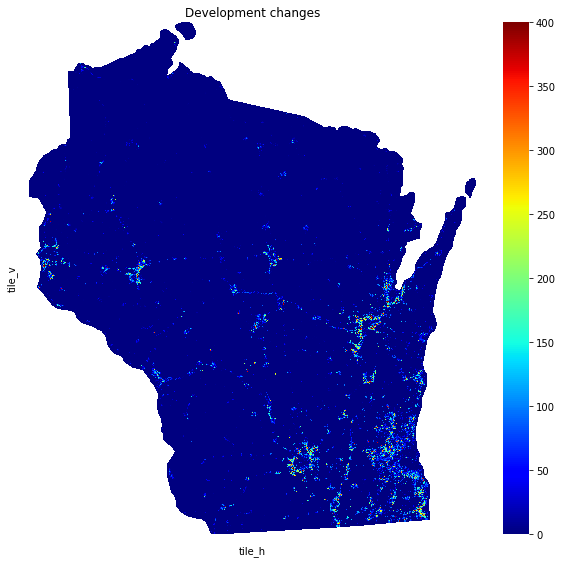

In [23]:
# for sizing of pictures later:
figsize_x = 10
figsize_y = (df_result["tile_h"].max())/(df_result["tile_v"].max()) * 10
pivotted = df_result.pivot('tile_v','tile_h','target')
import seaborn as sns
plt.figure(figsize=(figsize_x,figsize_y))
target_map = sns.heatmap(pivotted, cmap='jet', vmax = 400)
target_map.set_title("Development changes")
target_map.tick_params(left=False, bottom= False)
target_map.set(xticklabels=[], yticklabels=[])
target_map.set_facecolor('white')

In [24]:
df_result.target.mean()

4.519004124773271

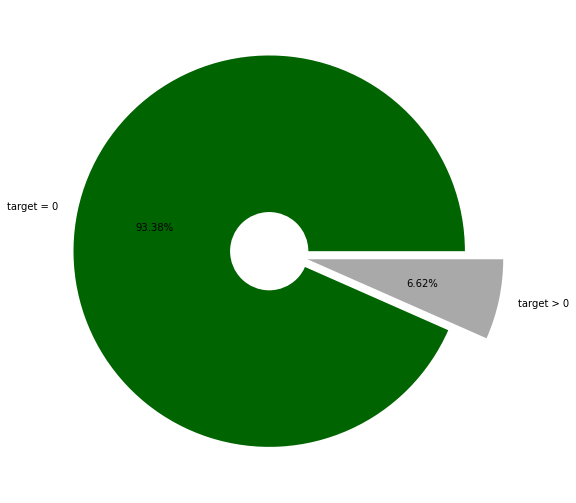

In [25]:
explode = (0, 0.2)
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)

plt.pie([df_result.target[df_result.target == 0].shape[0],df_result.target[df_result.target > 0].shape[0]],
        labels=['target = 0','target > 0'],
        colors=['darkgreen','darkgrey'],
        shadow=False,
        autopct ='%1.2f%%',
        explode=explode
       )
centre_circle = plt.Circle((0,0),0.20,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.set_size_inches(9,9)

plt.savefig('pie_non.png')

In [27]:
df_result.loc[(df_result.has_target == 1),'target'] = 0

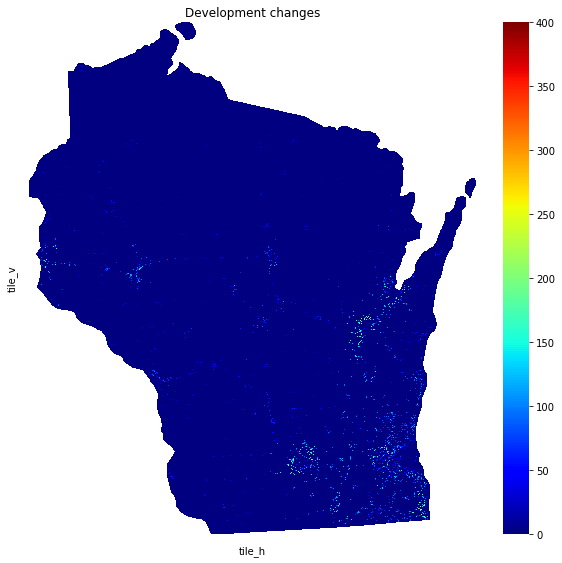

In [28]:
# for sizing of pictures later:
figsize_x = 10
figsize_y = (df_result["tile_h"].max())/(df_result["tile_v"].max()) * 10
pivotted = df_result.pivot('tile_v','tile_h','target')
import seaborn as sns
plt.figure(figsize=(figsize_x,figsize_y))
target_map = sns.heatmap(pivotted, cmap='jet', vmax = 400)
target_map.set_title("Development changes")
target_map.tick_params(left=False, bottom= False)
target_map.set(xticklabels=[], yticklabels=[])
target_map.set_facecolor('white')

In [30]:
np.sum(df_result.protected_area_tnc[(df_result.protected_area_tnc > 0) & (df_result.target > 0)])

427